In [155]:
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras.layers import Conv2D, Activation, Input, Add
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers.pooling import MaxPooling2D

#to detect and align faces and find distances
#!pip install deepface
from deepface.commons import functions, distance as dst

# DeepID 

This model is developed by The Chinese University of Hong Kong

Ref: http://mmlab.ie.cuhk.edu.hk/pdf/YiSun_CVPR14.pdf

In [2]:
def build_deepid_model():
    
    myInput = Input(shape=(55, 47, 3))
    
    x = Conv2D(20, (4, 4), name='Conv1', activation='relu', input_shape=(55, 47, 3))(myInput)
    x = MaxPooling2D(pool_size=2, strides=2, name='Pool1')(x)
    x = Dropout(rate=1, name='D1')(x)
    
    x = Conv2D(40, (3, 3), name='Conv2', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2, name='Pool2')(x)
    x = Dropout(rate=1, name='D2')(x)
    
    x = Conv2D(60, (3, 3), name='Conv3', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2, name='Pool3')(x)
    x = Dropout(rate=1, name='D3')(x)
    
    #--------------------------------------
    
    x1 = Flatten()(x)
    fc11 = Dense(160, name = 'fc11')(x1)
    
    #--------------------------------------
    
    x2 = Conv2D(80, (2, 2), name='Conv4', activation='relu')(x)
    x2 = Flatten()(x2)
    fc12 = Dense(160, name = 'fc12')(x2)
    
    #--------------------------------------
    
    y = Add()([fc11, fc12])
    y = Activation('relu', name = 'deepid')(y)
    
    model = Model(inputs=[myInput], outputs=y)
    
    return model

In [3]:
model = build_deepid_model()

# Loading pre-trained weights

Even though the original study is shared the structure of the network publicly, pre-trained weights is not shared. Roy Ran in open source community re-trained the DeepID model and shared trained weights in TensorFlow format here: https://github.com/Ruoyiran/DeepID . This model got 99.39% accuracy for validation set and 97.05% accuracy for test set in the best epoch.

I convert TensorFlow weights to Keras. [Here](https://github.com/serengil/tensorflow-101/blob/master/python/deepid-tf-to-keras.ipynb), you can find how to convert TensorFlow weights to Keras.

In [5]:
# load pre-trained weights
model.load_weights("deepid_keras_weights.h5")

In [7]:
#model.summary()

In [385]:
target_size_x = model.layers[0].input_shape[1:3][0]
target_size_y = model.layers[0].input_shape[1:3][1]
print("model input shape is (",target_size_x," x ",target_size_y,")")

model input shape is ( 55  x  47 )


# Data set

In [291]:
# Data set: https://github.com/serengil/deepface/tree/master/tests/dataset
idendities = {
    "Angelina": ["img2.jpg", "img4.jpg", "img6.jpg"],
    "Katy": ["img42.jpg", "img44.jpg", "img45.jpg"],
    "Scarlett": ["img9.jpg", "img48.jpg", "img49.jpg"],
}

In [292]:
positives = []

for key, values in idendities.items():
    
    #print(key)
    for i in range(0, len(values)-1):
        for j in range(i+1, len(values)):
            #print(values[i], " and ", values[j])
            positive = []
            positive.append(values[i])
            positive.append(values[j])
            positives.append(positive)


positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"

In [293]:
samples_list = list(idendities.values())

negatives = []

for i in range(0, len(idendities) - 1):
    for j in range(i+1, len(idendities)):
        #print(samples_list[i], " vs ",samples_list[j]) 
        cross_product = itertools.product(samples_list[i], samples_list[j])
        cross_product = list(cross_product)
        #print(cross_product)
        
        for cross_sample in cross_product:
            #print(cross_sample[0], " vs ", cross_sample[1])
            negative = []
            negative.append(cross_sample[0])
            negative.append(cross_sample[1])
            negatives.append(negative)
            
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

In [294]:
negatives = negatives.sample(positives.shape[0], random_state=17)

In [295]:
df = pd.concat([positives, negatives]).reset_index(drop = True)

In [296]:
df.shape

(18, 3)

In [297]:
df.decision.value_counts()

No     9
Yes    9
Name: decision, dtype: int64

In [298]:
df.file_x = "deepface/tests/dataset/"+df.file_x
df.file_y = "deepface/tests/dataset/"+df.file_y

In [299]:
df.head()

,file_x,file_y,decision
0,deepface/tests/dataset/img42.jpg,deepface/tests/dataset/img44.jpg,Yes
1,deepface/tests/dataset/img42.jpg,deepface/tests/dataset/img45.jpg,Yes
2,deepface/tests/dataset/img44.jpg,deepface/tests/dataset/img45.jpg,Yes
3,deepface/tests/dataset/img2.jpg,deepface/tests/dataset/img4.jpg,Yes
4,deepface/tests/dataset/img2.jpg,deepface/tests/dataset/img6.jpg,Yes


In [300]:
df.shape

(18, 3)

In [301]:
metrics = ["cosine", "euclidean", "euclidean_l2"]

for metric in metrics:
    df["DeepID_%s" % (metric)] = 0

In [302]:
#for index, instance in df.iterrows():
for index, instance in tqdm(df.iterrows(), total=df.shape[0]):
    img1_path = instance["file_x"]
    img2_path = instance["file_y"]
    
    img1 = functions.detectFace(img1_path, (target_size_y, target_size_x))
    img2 =  functions.detectFace(img2_path, (target_size_y, target_size_x))
    
    img1_representation = model.predict(img1)[0,:]
    img2_representation = model.predict(img2)[0,:]
    
    for j in metrics:
        if j == 'cosine':
            distance = dst.findCosineDistance(img1_representation, img2_representation)
        elif j == 'euclidean':
            distance = dst.findEuclideanDistance(img1_representation, img2_representation)
        elif j == 'euclidean_l2':
            distance = dst.findEuclideanDistance(dst.l2_normalize(img1_representation), dst.l2_normalize(img2_representation))
        
        df.loc[index, 'DeepID_%s' % (j)] = distance

100%|██████████| 18/18 [00:26<00:00,  1.48s/it]


In [303]:
df

,file_x,file_y,decision,DeepID_cosine,DeepID_euclidean,DeepID_euclidean_l2
0,deepface/tests/dataset/img42.jpg,deepface/tests/dataset/img44.jpg,Yes,0.007974,41.809601,0.126285
1,deepface/tests/dataset/img42.jpg,deepface/tests/dataset/img45.jpg,Yes,0.007995,33.246384,0.126451
2,deepface/tests/dataset/img44.jpg,deepface/tests/dataset/img45.jpg,Yes,0.009873,36.760593,0.140519
3,deepface/tests/dataset/img2.jpg,deepface/tests/dataset/img4.jpg,Yes,0.010985,39.810478,0.148223
4,deepface/tests/dataset/img2.jpg,deepface/tests/dataset/img6.jpg,Yes,0.007362,32.632843,0.121344
5,deepface/tests/dataset/img4.jpg,deepface/tests/dataset/img6.jpg,Yes,0.013674,43.996525,0.165372
6,deepface/tests/dataset/img9.jpg,deepface/tests/dataset/img48.jpg,Yes,0.014452,42.928707,0.170013
7,deepface/tests/dataset/img9.jpg,deepface/tests/dataset/img49.jpg,Yes,0.007572,40.581459,0.123064
8,deepface/tests/dataset/img48.jpg,deepface/tests/dataset/img49.jpg,Yes,0.010904,45.762234,0.147678
9,deepface/tests/dataset/img6.jpg,deepface/tests/dataset/img48.jpg,No,0.021625,55.636730,0.207965


cosine


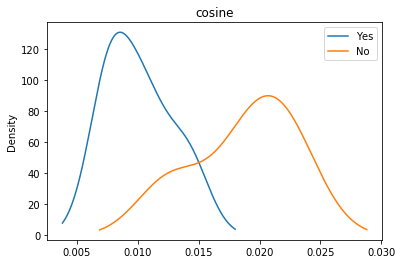

euclidean


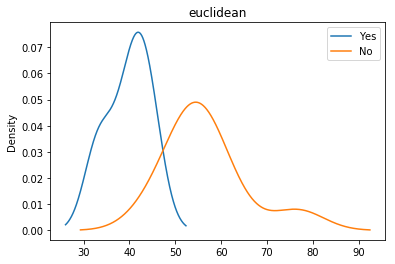

euclidean_l2


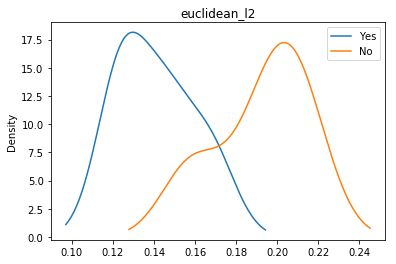

In [304]:
for metric in metrics:
    print(metric)
    df[df.decision == "Yes"]['DeepID_%s' % (metric)].plot(kind='kde', title = metric, label = 'Yes', legend = True)
    df[df.decision == "No"]['DeepID_%s' % (metric)].plot(kind='kde', title = metric, label = 'No', legend = True)
    plt.show()

In [337]:
df.head()

,file_x,file_y,decision,DeepID_cosine,DeepID_euclidean,DeepID_euclidean_l2
0,deepface/tests/dataset/img42.jpg,deepface/tests/dataset/img44.jpg,Yes,0.007974,41.809601,0.126285
1,deepface/tests/dataset/img42.jpg,deepface/tests/dataset/img45.jpg,Yes,0.007995,33.246384,0.126451
2,deepface/tests/dataset/img44.jpg,deepface/tests/dataset/img45.jpg,Yes,0.009873,36.760593,0.140519
3,deepface/tests/dataset/img2.jpg,deepface/tests/dataset/img4.jpg,Yes,0.010985,39.810478,0.148223
4,deepface/tests/dataset/img2.jpg,deepface/tests/dataset/img6.jpg,Yes,0.007362,32.632843,0.121344


In [349]:
def showInstance(idx):
    fig = plt.figure(figsize=(10,3))

    ax1 = fig.add_subplot(1,3,1)
    plt.imshow(functions.detectFace(df.iloc[idx].file_x, (224, 224))[0][:,:,::-1])
    plt.axis('off')

    ax2 = fig.add_subplot(1,3,2)
    plt.imshow(functions.detectFace(df.iloc[idx].file_y, (224, 224))[0][:,:,::-1])
    plt.axis('off')

    ax3 = fig.add_subplot(1,3,3)
    plt.text(0, 0.6, "Cosine: %s" % (round(df.iloc[idx].DeepID_cosine,4)))
    plt.text(0, 0.5, "Euclidean: %s" % (round(df.iloc[idx].DeepID_euclidean,4)))
    plt.text(0, 0.4, "Euclidean L2: %s" % (round(df.iloc[idx].DeepID_euclidean_l2,4)))
    plt.axis('off')

    plt.show()

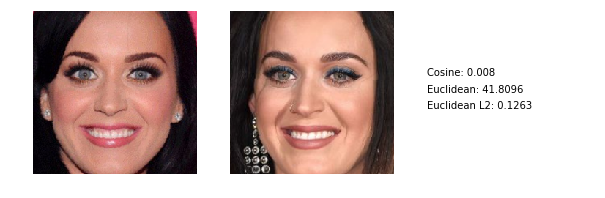

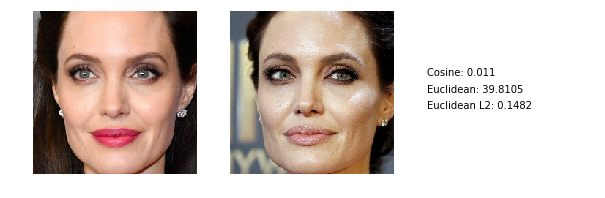

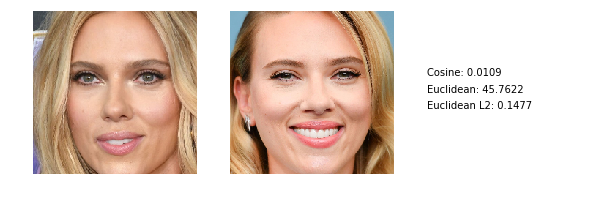

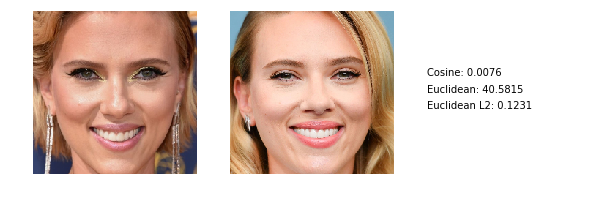

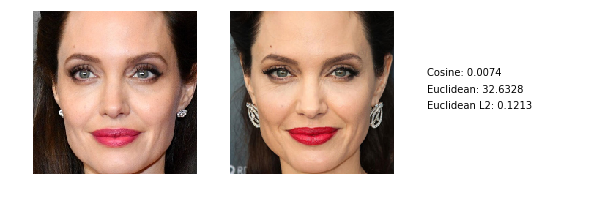

In [388]:
for i in df[df.decision == 'Yes'].sample(5, random_state=666).index.tolist():
    showInstance(i)

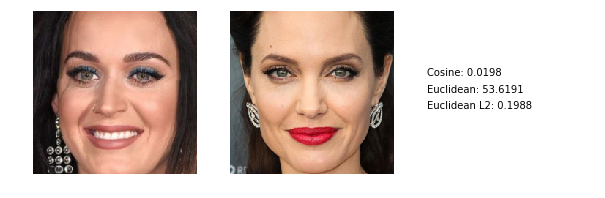

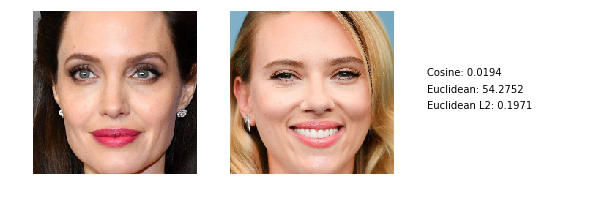

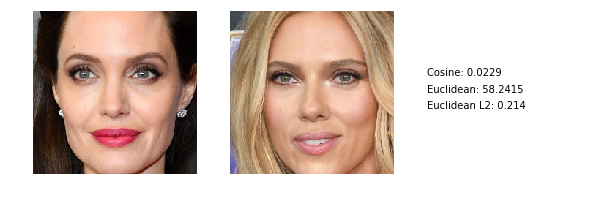

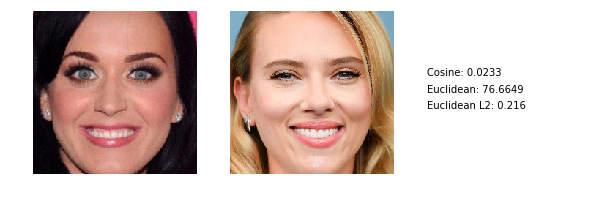

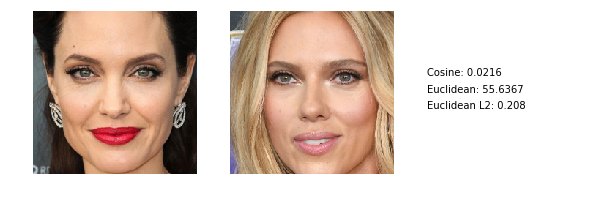

In [390]:
for i in df[df.decision == 'No'].sample(5, random_state=17).index.tolist():
    showInstance(i)

In [391]:
print("Cosine: ")
threshold = 0.015

print("actual values of verified ones: ",df[df['DeepID_cosine'] <= threshold].decision.values)
print("actual values of unverified ones: ",df[df['DeepID_cosine'] > threshold].decision.values)

print("------------------------")

print("Euclidean:")
threshold = 45

print("actual values of verified ones: ",df[df['DeepID_euclidean'] <= threshold].decision.values)
print("actual values of unverified ones: ",df[df['DeepID_euclidean'] > threshold].decision.values)

print("------------------------")

print("Euclidean L2:")
threshold = 0.17

print("actual values of verified ones: ",df[df['DeepID_euclidean_l2'] <= threshold].decision.values)
print("actual values of unverified ones: ",df[df['DeepID_euclidean_l2'] > threshold].decision.values)

Cosine: 
actual values of verified ones:  ['Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'No']
actual values of unverified ones:  ['No' 'No' 'No' 'No' 'No' 'No' 'No']
------------------------
Euclidean:
actual values of verified ones:  ['Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes']
actual values of unverified ones:  ['Yes' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No']
------------------------
Euclidean L2:
actual values of verified ones:  ['Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'No']
actual values of unverified ones:  ['Yes' 'No' 'No' 'No' 'No' 'No' 'No' 'No']
